<a href="https://colab.research.google.com/github/SalarShafiee/Image-classification/blob/main/NLP%20Aufgabe%2010%2C12%2C2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**About this Notebook / Project**

In this notebook I have choosed a "**Text classification**" task as my final assessment. I want to go through the comments which are entirely in english and come either from Civil Comments or Wikipedia talk page edits. The test data's comment_text columns are composed of multiple non-English languages.

the data is originally from Jigsaw competitions on Kaggel.



**the link for dataset is**

https://www.kaggle.com/competitions/jigsaw-multilingual-toxic-comment-classification/overview


**Main purpose of the task**

The main purpose is to develope a Deep learning model to recognize and classify the generated text on web as a "toxic rude" comment or safe comment. this will make the surfing enviroment much more safer and healthier.


**1- Getting the reuquired permissions to access the dataset from kaggel**

In [6]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


** 2-Downloading the dataset from kaggel with Kaggelhub **

In [7]:
jigsaw_multilingual_toxic_comment_classification_path = kagglehub.competition_download('jigsaw-multilingual-toxic-comment-classification')
takuok_glove840b300dtxt_path = kagglehub.dataset_download('takuok/glove840b300dtxt')

print('Data source import complete.')


100%|██████████| 1.08G/1.08G [00:48<00:00, 23.9MB/s]

Extracting files...


100%|██████████| 2.08G/2.08G [01:30<00:00, 24.6MB/s]

Extracting files...


Data source import complete.


In this notebook, I'm going to progress from very basic RNNs all the way to more sophisticated deep learning architectures. I will test my knowledge for text classification wirh LLM methods with **simple RNNs**, **Word Embeddings**, **LSTMs**, **GRUs**, and **bi-directional RNNs** . I will also show my knowledge statuse with **Encoder-Decoder Architectures**, or Seq2Seq models with attention. It will finish with current state-of-the-art models, namely **transformers** and **BERT**.

Finally I will compare the results of text classification ( toxic comment classification ) with each LLM method.

**1-Importing the necessary Libraries**

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU,SimpleRNN
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D # Import from tensorflow.keras.layers
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# Configuring TPU's

For this version of Notebook we will be using TPU's as we have to built a BERT Model

In [10]:
# Detect hardware, return appropriate distribution strategy
#try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
   # tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
   # print('Running on TPU ', tpu.master())
#except ValueError:
   # tpu = None

In [11]:

#if tpu:
    #tf.config.experimental_connect_to_cluster(tpu)
   # tf.tpu.experimental.initialize_tpu_system(tpu)
    #strategy = tf.distribute.experimental.TPUStrategy(tpu)
#else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
   # strategy = tf.distribute.get_strategy()

#print("REPLICAS: ", strategy.num_replicas_in_sync)

**Here we will download the data and structure in 3 different folder of Train, Validation and Test**

In [12]:
train = pd.read_csv("/root/.cache/kagglehub/competitions/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
validation = pd.read_csv('/root/.cache/kagglehub/competitions/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/root/.cache/kagglehub/competitions/jigsaw-multilingual-toxic-comment-classification/test.csv')

**lets look at our data**

In [14]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


**How balance is our Dataset ?**

As we can see below, almost 90% of the data belongs to the class 0 (non-toxic) and almost 10 precent is belong to class 1 (toxic).

We can take two different approaches:
1- over / under sample the data
2- choose a better performance metric rather than Accuracy

**We will take the Second approach**

In [15]:

class_counts = train['toxic'].value_counts()

class_proportions = class_counts / len(train)

print(class_proportions)


is_balanced = all(0.45 < prop < 0.55 for prop in class_proportions)

if is_balanced:
    print("Classes are approximately balanced.")
else:
    print("Classes are imbalanced.")

toxic
0    0.904343
1    0.095657
Name: count, dtype: float64
Classes are imbalanced.


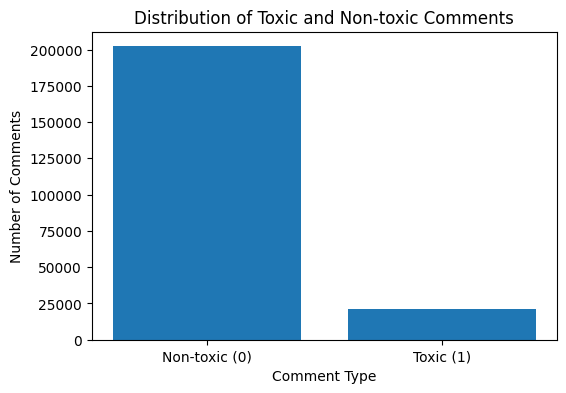

In [18]:
import matplotlib.pyplot as plt


class_counts = train['toxic'].value_counts()


plt.figure(figsize=(6, 4))
plt.bar(class_counts.index, class_counts.values)
plt.xticks(class_counts.index, ['Non-toxic (0)', 'Toxic (1)'])
plt.xlabel('Comment Type')
plt.ylabel('Number of Comments')
plt.title('Distribution of Toxic and Non-toxic Comments')
plt.show()

I will drop the other columns and approach this problem as a **Binary Classification** Problem and also we will have our exercise done on a smaller subsection of the dataset**(only 20000 data points)** to make it easier to train the models

In [19]:
train.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True)

In [20]:
train = train.loc[:20000,:]
train.shape

(20001, 3)

In [21]:
train.head()

,id,comment_text,toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0


**I will check the maximum number of words that can be present in a comment , this will help us in padding that The RNN models During training phase need to be fed.**

In [22]:
train['comment_text'].apply(lambda x:len(str(x).split())).max()

1403

Since my data in unbalanced, I will take  **AUC**, **F1** and **Recall** as and performance metric. I will write a Definition, so I can use it later.

In [24]:
from sklearn.metrics import roc_curve, auc, f1_score, recall_score

def evaluate_model(predictions, target):

    fpr, tpr, thresholds = roc_curve(target, predictions)
    roc_auc_score = auc(fpr, tpr)


    predicted_labels = (predictions >= 0.5).astype(int)
    f1 = f1_score(target, predicted_labels)
    recall = recall_score(target, predicted_labels)

    return roc_auc_score, f1, recall





**Data Preparation**

Train_test spit: I take 20% of the training set for test on final model performance evaluation.

In [25]:
x_train, x_valid, y_train, y_valid = train_test_split(train.comment_text.values, train.toxic.values,
                                                  stratify=train.toxic.values,
                                                  random_state=42,
                                                  test_size=0.2, shuffle=True)

# Simple RNN Implementation

**Tokenization**

First we use keras tokenizer to convert each word in training and validation set to a specific number. I will then pass this as an input  to a look up table embedding layer and let the network to learn from the dictionary of words and devise an embedding with** 300 features**.

for the next LLM model. I will use a pretrainded embeding vector weights based on Gloves, to see any possible improve on the performance.

In [31]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 1500

token.fit_on_texts(list(x_train) + list(x_valid))
x_train_seq = token.texts_to_sequences(x_train)
x_valid_seq = token.texts_to_sequences(x_valid)

#zero pad the sequences
x_train_pad = sequence.pad_sequences(x_train_seq, maxlen=max_len)
x_valid_pad = sequence.pad_sequences(x_valid_seq, maxlen=max_len)

word_index = token.word_index

**Build the structure of a simple RNN model**

Our fisrt layer is a non-pretrained embedding layer and the hidden layer of our RNN has **100** neurons. (which is my chosen hyper parameter)

In [35]:
%%time
    # A simpleRNN without any pretrained embeddings and one dense layer
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len))
model.add(SimpleRNN(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

CPU times: user 22.3 ms, sys: 972 µs, total: 23.3 ms
Wall time: 22.3 ms


**Fit the model on train and validation dataset with 5 epochs**

I will also pass the mini-batch as 64 ( a Hyper paramether)

In [36]:
model.fit(
    x_train_pad,
    y_train,
    epochs=5,
    batch_size=64,
    validation_data=(x_valid_pad, y_valid)
)

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 45s 167ms/step - accuracy: 0.8841 - loss: 0.3407 - val_accuracy: 0.9163 - val_loss: 0.2353
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.9495 - loss: 0.1446 - val_accuracy: 0.9368 - val_loss: 0.1977
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.9857 - loss: 0.0440 - val_accuracy: 0.9348 - val_loss: 0.2217
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.9978 - loss: 0.0119 - val_accuracy: 0.9385 - val_loss: 0.2751
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 167ms/step - accuracy: 0.9999 - loss: 0.0026 - val_accuracy: 0.9413 - val_loss: 0.2630


Since the validation accuracy on this Hyperparameter is imprtant, we get the performance metric on Val_dataset

In [44]:
scores = model.predict(x_valid_pad)
roc_auc_score, f1, recall = evaluate_model(scores, y_valid)  # Unpack the values
print("AUC: %.2f%%, F1: %.2f, Recall: %.2f" % (roc_auc_score, f1, recall))

126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step
AUC: 0.87%, F1: 0.65, Recall: 0.55


In [45]:
scores_model = []
scores_model.append({
    'Model': 'SimpleRNN',
    'AUC_Score': roc_auc_score,
    'F1_Score': f1,
    'Recall_Score': recall
})

# Word Embeddings

In this Notebook, I'll be using the GloVe vectors, since for the next model I want to use a pretrained weight of and Embedding layer !)

In [46]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open("/root/.cache/kagglehub/datasets/takuok/glove840b300dtxt/versions/1/glove.840B.300d.txt",'r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196018it [02:41, 13599.50it/s]

Found 2196017 word vectors.


# LSTM
In this model I want to use a pretrained Embedding layer.

**Create an embedding matrix (Look-up table) for the words we have in the dataset**

In [47]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 58752/58752 [00:00<00:00, 336748.43it/s]


**LSTM model structure:**

we use 100 hidden neurons inside each LSTM units

we use a regularization technique (30% drop out)

we use recurrent connections drop_out (30%) to avoid overfitting

In [49]:
model = Sequential()
# puting the pretrained embedding layer
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │      17,625,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,625,900 (67.24 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 17,625,900 (67.24 MB)

In [50]:
model.fit(x_train_pad, y_train, epochs=5, batch_size=64)

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 243s 957ms/step - accuracy: 0.9089 - loss: 0.2562
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 237s 948ms/step - accuracy: 0.9462 - loss: 0.1561
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 241s 966ms/step - accuracy: 0.9564 - loss: 0.1197
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 240s 960ms/step - accuracy: 0.9560 - loss: 0.1139
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 240s 959ms/step - accuracy: 0.9616 - loss: 0.1033


In [51]:
scores = model.predict(x_valid_pad)
roc_auc_score, f1, recall = evaluate_model(scores, y_valid)
print("AUC: %.2f%%, F1: %.2f, Recall: %.2f" % (roc_auc_score, f1, recall))

126/126 ━━━━━━━━━━━━━━━━━━━━ 62s 490ms/step
AUC: 0.97%, F1: 0.75, Recall: 0.67


In [52]:
scores_model.append({
    'Model': 'LSTM',
    'AUC_Score': roc_auc_score,
    'F1_Score': f1,
    'Recall_Score': recall
})

-------------------------------تا اینجا 10.12.2024
## Code Explanation

As a first step we calculate embedding matrix for our vocabulary from the pretrained GLoVe vectors . Then while building the embedding layer we pass Embedding Matrix as weights to the layer instead of training it over Vocabulary and thus we pass trainable = False.
Rest of the model is same as before except we have replaced the SimpleRNN By LSTM Units

* Comments on the Model

We now see that the model is not overfitting and achieves an auc score of 0.96 which is quite commendable , also we close in on the gap between accuracy and auc .
We see that in this case we used dropout and prevented overfitting the data

# GRU's

## Basic  Overview

Introduced by Cho, et al. in 2014, GRU (Gated Recurrent Unit) aims to solve the vanishing gradient problem which comes with a standard recurrent neural network. GRU's are a variation on the LSTM because both are designed similarly and, in some cases, produce equally excellent results . GRU's were designed to be simpler and faster than LSTM's and in most cases produce equally good results and thus there is no clear winner.

## In Depth Explanation

* https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be
* https://www.coursera.org/learn/nlp-sequence-models/lecture/agZiL/gated-recurrent-unit-gru
* https://www.geeksforgeeks.org/gated-recurrent-unit-networks/

## Code Implementation

In [37]:
%%time
with strategy.scope():
    # GRU with glove embeddings and two dense layers
     model = Sequential()
     model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
     model.add(SpatialDropout1D(0.3))
     model.add(GRU(300))
     model.add(Dense(1, activation='sigmoid'))

     model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │      13,049,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,049,100 (49.78 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 13,049,100 (49.78 MB)

CPU times: user 79.8 ms, sys: 58.2 ms, total: 138 ms
Wall time: 136 ms


In [38]:
model.fit(xtrain_pad, ytrain, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 165ms/step - accuracy: 0.9079 - loss: 0.2721
Epoch 2/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 25s 166ms/step - accuracy: 0.9554 - loss: 0.1278
Epoch 3/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 25s 165ms/step - accuracy: 0.9580 - loss: 0.1088
Epoch 4/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 25s 169ms/step - accuracy: 0.9636 - loss: 0.0978
Epoch 5/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 25s 169ms/step - accuracy: 0.9691 - loss: 0.0808


In [39]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step
Auc: 0.98%


In [40]:
scores_model.append({'Model': 'GRU','AUC_Score': roc_auc(scores,yvalid)})

In [41]:
scores_model

[{'Model': 'SimpleRNN', 'AUC_Score': 0.8331219174140523},
 {'Model': 'LSTM', 'AUC_Score': 0.9807294051850262},
 {'Model': 'GRU', 'AUC_Score': 0.9769097341833198}]

# Bi-Directional RNN's

## In Depth Explanation

* https://www.coursera.org/learn/nlp-sequence-models/lecture/fyXnn/bidirectional-rnn
* https://towardsdatascience.com/understanding-bidirectional-rnn-in-pytorch-5bd25a5dd66
* https://d2l.ai/chapter_recurrent-modern/bi-rnn.html

## Code Implementation

In [42]:
%%time
with strategy.scope():
    # A simple bidirectional LSTM with glove embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
    model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])


model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │      13,049,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,049,100 (49.78 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 13,049,100 (49.78 MB)

CPU times: user 95.7 ms, sys: 59.2 ms, total: 155 ms
Wall time: 153 ms


In [44]:
model.fit(xtrain_pad, ytrain, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.8953 - loss: 0.2748
Epoch 2/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.9366 - loss: 0.1727
Epoch 3/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.9497 - loss: 0.1445
Epoch 4/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.9532 - loss: 0.1283
Epoch 5/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.9600 - loss: 0.1159


In [45]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

76/76 ━━━━━━━━━━━━━━━━━━━━ 50s 655ms/step
Auc: 0.97%


In [46]:
scores_model.append({'Model': 'Bi-directional LSTM','AUC_Score': roc_auc(scores,yvalid)})

## Code Explanation

Code is same as before,only we have added bidirectional nature to the LSTM cells we used before and is self explanatory. We have achieve similar accuracy and auc score as before and now we have learned all the types of typical RNN architectures

**We are now at the end of part 1 of this notebook and things are about to go wild now as we Enter more complex and State of the art models .If you have followed along from the starting and read all the articles and understood everything , these complex models would be fairly easy to understand.I recommend Finishing Part 1 before continuing as the upcoming techniques can be quite overwhelming**

# Seq2Seq Model Architecture

## Overview

RNN's are of many types  and different architectures are used for different purposes. Here is a nice video explanining different types of model architectures : https://www.coursera.org/learn/nlp-sequence-models/lecture/BO8PS/different-types-of-rnns.
Seq2Seq is a many to many RNN architecture where the input is a sequence and the output is also a sequence (where input and output sequences can be or cannot be of different lengths). This architecture is used in a lot of applications like Machine Translation, text summarization, question answering etc

## In Depth Understanding

I will not write the code implementation for this,but rather I will provide the resources where code has already been implemented and explained in a much better way than I could have ever explained.

* https://www.coursera.org/learn/nlp-sequence-models/lecture/HyEui/basic-models ---> A basic idea of different Seq2Seq Models

* https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html , https://machinelearningmastery.com/define-encoder-decoder-sequence-sequence-model-neural-machine-translation-keras/ ---> Basic Encoder-Decoder Model and its explanation respectively

* https://towardsdatascience.com/how-to-implement-seq2seq-lstm-model-in-keras-shortcutnlp-6f355f3e5639 ---> A More advanced Seq2seq Model and its explanation

* https://d2l.ai/chapter_recurrent-modern/machine-translation-and-dataset.html , https://d2l.ai/chapter_recurrent-modern/encoder-decoder.html ---> Implementation of Encoder-Decoder Model from scratch

* https://www.youtube.com/watch?v=IfsjMg4fLWQ&list=PLtmWHNX-gukKocXQOkQjuVxglSDYWsSh9&index=8&t=0s ---> Introduction to Seq2seq By fast.ai

In [47]:
# Visualization of Results obtained from various Deep learning models
results = pd.DataFrame(scores_model).sort_values(by='AUC_Score',ascending=False)
results.style.background_gradient(cmap='Blues')

,Model,AUC_Score
1,LSTM,0.980729
2,GRU,0.976910
3,Bi-directional LSTM,0.970719
0,SimpleRNN,0.833122


In [48]:
fig = go.Figure(go.Funnelarea(
    text =results.Model,
    values = results.AUC_Score,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

# Attention Models

This is the toughest and most tricky part. If you are able to understand the intiuition and working of attention block , understanding transformers and transformer based architectures like BERT will be a piece of cake. This is the part where I spent the most time on and I suggest you do the same . Please read and view the following resources in the order I am providing to ignore getting confused, also at the end of this try to write and draw an attention block in your own way :-

* https://www.coursera.org/learn/nlp-sequence-models/lecture/RDXpX/attention-model-intuition --> Only watch this video and not the next one
* https://towardsdatascience.com/sequence-2-sequence-model-with-attention-mechanism-9e9ca2a613a
* https://towardsdatascience.com/attention-and-its-different-forms-7fc3674d14dc
* https://distill.pub/2016/augmented-rnns/

## Code Implementation

* https://www.analyticsvidhya.com/blog/2019/11/comprehensive-guide-attention-mechanism-deep-learning/ --> Basic Level
* https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html ---> Implementation from Scratch in Pytorch

# Transformers : Attention is all you need

So finally we have reached the end of the learning curve and are about to start learning the technology that changed NLP completely and are the reasons for the state of the art NLP techniques .Transformers were introduced in the paper Attention is all you need by Google. If you have understood the Attention models,this will be very easy , Here is transformers fully explained:

* http://jalammar.github.io/illustrated-transformer/

## Code Implementation

* http://nlp.seas.harvard.edu/2018/04/03/attention.html ---> This presents the code implementation of the architecture presented in the paper by Google

# BERT and Its Implementation on this Competition

As Promised I am back with Resiurces , to understand about BERT architecture , please follow the contents in the given order :-

* http://jalammar.github.io/illustrated-bert/ ---> In Depth Understanding of BERT

After going through the post Above , I guess you must have understood how transformer architecture have been utilized by the current SOTA models . Now these architectures can be used in two ways :<br><br>
1) We can use the model for prediction on our problems using the pretrained weights without fine-tuning or training the model for our sepcific tasks
* EG: http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/ ---> Using Pre-trained BERT without Tuning

2) We can fine-tune or train these transformer models for our task by tweaking the already pre-trained weights and training on a much smaller dataset
* EG:* https://www.youtube.com/watch?v=hinZO--TEk4&t=2933s ---> Tuning BERT For your TASK

We will be using the first example as a base for our implementation of BERT model using Hugging Face and KERAS , but contrary to first example we will also Fine-Tune our model for our task

Acknowledgements : https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras


Steps Involved :
* Data Preparation : Tokenization and encoding of data
* Configuring TPU's
* Building a Function for Model Training and adding an output layer for classification
* Train the model and get the results

In [ ]:
# Loading Dependencies
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers

from tokenizers import BertWordPieceTokenizer

In [ ]:
# LOADING THE DATA

train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

Encoder FOr DATA for understanding waht encode batch does read documentation of hugging face tokenizer :
https://huggingface.co/transformers/main_classes/tokenizer.html here

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    Encoder for encoding the text into sequence of integers for BERT Input
    """
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []

    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])

    return np.array(all_ids)

In [ ]:
#IMP DATA FOR CONFIG

AUTO = tf.data.experimental.AUTOTUNE


# Configuration
EPOCHS = 3
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 192

## Tokenization

For understanding please refer to hugging face documentation again

In [ ]:
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

In [ ]:
x_train = fast_encode(train1.comment_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_valid = fast_encode(valid.comment_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_test = fast_encode(test.content.astype(str), fast_tokenizer, maxlen=MAX_LEN)

y_train = train1.toxic.values
y_valid = valid.toxic.values

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

In [ ]:
def build_model(transformer, max_len=512):
    """
    function for training the BERT model
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)

    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

    return model

## Starting Training

If you want to use any another model just replace the model name in transformers._____ and use accordingly

In [ ]:
%%time
with strategy.scope():
    transformer_layer = (
        transformers.TFDistilBertModel
        .from_pretrained('distilbert-base-multilingual-cased')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

In [ ]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

In [ ]:
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=EPOCHS*2
)

In [ ]:
sub['toxic'] = model.predict(test_dataset, verbose=1)
sub.to_csv('submission.csv', index=False)

# End Notes

This was my effort to share my learnings so that everyone can benifit from it.As this community has been very kind to me and helped me in learning all of this , I want to take this forward. I have shared all the resources I used to learn all the stuff .Join me and make these NLP competitions your first ,without being overwhelmed by the shear number of techniques used . It took me 10 days to learn all of this , you can learn it at your pace and dont give in , at the end of all this you will be a different person and it will all be worth it.


### I am attaching more resources if you want NLP end to end:

1) Books

* https://d2l.ai/
* Jason Brownlee's Books

2) Courses

* https://www.coursera.org/learn/nlp-sequence-models/home/welcome
* Fast.ai NLP Course

3) Blogs and websites

* Machine Learning Mastery
* https://distill.pub/
* http://jalammar.github.io/

**<span style="color:Red">This is subtle effort of contributing towards the community, if it helped you in any way please show a token of love by upvoting**